In [1]:
import pandas as pd
import glob


In [3]:

# 1. Collect all CSV file paths from the tracking_data/ folder
all_files = glob.glob("tracking_data/*.csv")

# 2. Read each CSV into a DataFrame
df_list = [pd.read_csv(f) for f in all_files]

# 3. Merge all CSVs into one big dataset
dataset = pd.concat(df_list, ignore_index=True)

# 4. Preview dataset
print(dataset.head())


   frame  time_s      x     y      w      h     cx     cy
0      0  0.0000  231.0  67.0  105.0  230.0  283.5  182.0
1      1  0.0334  232.8  69.3  103.0  225.0  284.3  181.8
2      2  0.0667  231.9  66.0  105.0  230.0  284.4  181.0
3      3  0.1001  232.1  64.8  105.0  230.0  284.6  179.8
4      4  0.1335  230.3  59.3  109.0  239.0  284.8  178.8


In [5]:
dataset.shape


(3607, 8)

In [7]:
import matplotlib.pyplot as plt

# Check what columns exist
print(dataset.columns)



Index(['frame', 'time_s', 'x', 'y', 'w', 'h', 'cx', 'cy'], dtype='object')


In [9]:

obj_id = dataset['object_id'].iloc[0]   # take first object
obj_data = dataset[dataset['object_id'] == obj_id]

plt.plot(obj_data['x'], obj_data['y'], marker='o')
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title(f"Trajectory of Object {obj_id}")
plt.show()


KeyError: 'object_id'

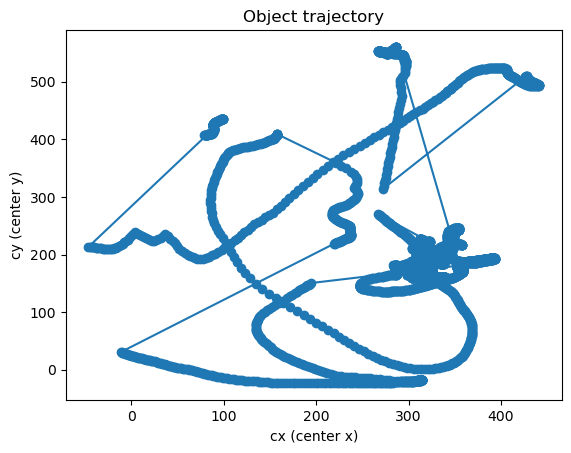

In [11]:
# Plot center positions across frames
plt.plot(dataset['cx'], dataset['cy'], marker='o')
plt.xlabel("cx (center x)")
plt.ylabel("cy (center y)")
plt.title("Object trajectory")
plt.show()

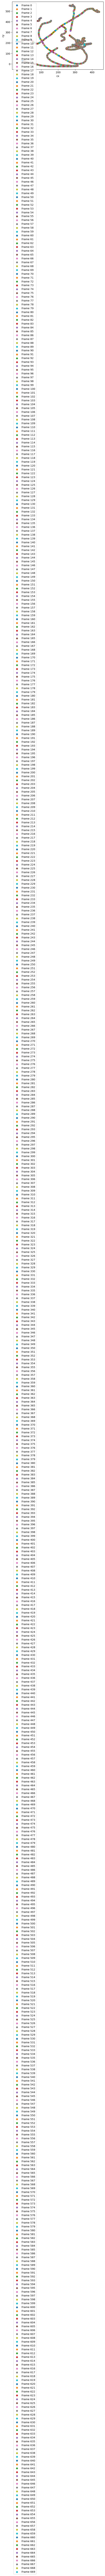

In [13]:
for frame_num in dataset['frame'].unique():
    frame_data = dataset[dataset['frame'] == frame_num]
    plt.scatter(frame_data['cx'], frame_data['cy'], label=f"Frame {frame_num}")

plt.xlabel("cx")
plt.ylabel("cy")
plt.legend()
plt.show()


In [15]:
import glob, pandas as pd, numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error


In [17]:

# Load all CSVs you created
all_files = glob.glob("tracking_data/*.csv")
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

# Sort just in case
df = df.sort_values(["time_s", "frame"]).reset_index(drop=True)

# Build sliding-window sequences of centers
W = 15  # look-back window (frames)
X, yx, yy = [], [], []
centers = df[["cx","cy"]].to_numpy()

for i in range(len(centers) - W):
    window = centers[i:i+W]          # shape (W, 2)
    X.append(window.flatten())       # (2W,) -> [cx1,cy1,...,cxW,cyW]
    yx.append(centers[i+W, 0])       # next cx
    yy.append(centers[i+W, 1])       # next cy

X = np.array(X)
yx = np.array(yx)
yy = np.array(yy)

# Split train/val (simple split)
split = int(0.8 * len(X))
Xtr, Xva = X[:split], X[split:]
yx_tr, yx_va = yx[:split], yx[split:]
yy_tr, yy_va = yy[:split], yy[split:]

# Train two regressors (one for cx, one for cy)
mx = Ridge(alpha=1.0).fit(Xtr, yx_tr)
my = Ridge(alpha=1.0).fit(Xtr, yy_tr)

# Validate
pred_cx = mx.predict(Xva)
pred_cy = my.predict(Xva)
print("MAE cx:", mean_absolute_error(yx_va, pred_cx))
print("MAE cy:", mean_absolute_error(yy_va, pred_cy))

MAE cx: 49.247327520606206
MAE cy: 28.865195387709313


In [9]:
import os

video_path = r"C:\Users\user\machine-Learning-Project\object-tracking-project\videos\video1.mp4"
print(os.path.exists(video_path))  # must print True



True


In [11]:
import cv2
import numpy as np

def create_tracker(name="csrt"):
    name = name.lower()
    if name == "csrt": return cv2.TrackerCSRT_create()
    if name == "kcf":  return cv2.TrackerKCF_create()
    if name == "mosse":
        return cv2.legacy.TrackerMOSSE_create() if hasattr(cv2, "legacy") else cv2.TrackerMOSSE_create()
    raise ValueError("tracker must be csrt|kcf|mosse")

video_path = r"C:\Users\user\machine-Learning-Project\object-tracking-project\videos\video1.mp4"
  # pick one of your 10 videos
cap = cv2.VideoCapture(video_path)
ok, frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video")

# --- pick initial ROI once ---
bbox = cv2.selectROI("Select object", frame, False, False)
cv2.destroyAllWindows()

tracker = create_tracker("csrt")
tracker.init(frame, bbox)

# Rolling window buffer (start with first center)
x, y, w, h = bbox
cx, cy = x + w/2, y + h/2
buf = [(cx, cy)] * W   # seed with same point

alpha_blend = 0.7  # when tracker ok: final = alpha*tracker + (1-alpha)*ML

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("tracked_fused.mp4", fourcc,
                      cap.get(cv2.CAP_PROP_FPS) or 30.0,
                      (frame.shape[1], frame.shape[0]))

while True:
    ok, frame = cap.read()
    if not ok: break

    ok_t, box = tracker.update(frame)
    # Prepare ML input from the last W centers
    Xwin = np.array(buf[-W:]).flatten().reshape(1, -1)
    ml_cx = mx.predict(Xwin)[0]
    ml_cy = my.predict(Xwin)[0]

    if ok_t:
        x, y, w, h = box
        tr_cx, tr_cy = x + w/2, y + h/2
        # Blend tracker center with ML prediction (stabilize)
        fcx = alpha_blend * tr_cx + (1 - alpha_blend) * ml_cx
        fcy = alpha_blend * tr_cy + (1 - alpha_blend) * ml_cy
        # recentre the box (keep size)
        x = fcx - w/2; y = fcy - h/2
        final_box = (int(x), int(y), int(w), int(h))
    else:
        # tracker lost → use ML prediction to keep going
        fcx, fcy = ml_cx, ml_cy
        final_box = (int(fcx - w/2), int(fcy - h/2), int(w), int(h))
        # Optionally try to re-init tracker around predicted box:
        tracker = create_tracker("csrt")
        tracker.init(frame, final_box)

    # Update buffer with the fused/predicted center
    buf.append((float(final_box[0] + final_box[2]/2),
                float(final_box[1] + final_box[3]/2)))

    # Draw & write
    p1 = (final_box[0], final_box[1])
    p2 = (final_box[0] + final_box[2], final_box[1] + final_box[3])
    cv2.rectangle(frame, p1, p2, (0,255,0), 2)
    cv2.circle(frame, (int(buf[-1][0]), int(buf[-1][1])), 3, (255,0,0), -1)
    cv2.putText(frame, f"Fused: tracker {'OK' if ok_t else 'LOST'}",
                (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    out.write(frame)
    cv2.imshow("Real-time ML+Tracker", frame)
    if cv2.waitKey(1) & 0xFF in (27, ord('q')): break

cap.release(); out.release(); cv2.destroyAllWindows()


NameError: name 'W' is not defined

In [21]:
pip install opencv-python


  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [27]:
pip install numpy==1.26.4


Note: you may need to restart the kernel to use updated packages.Collecting numpy==1.26.4
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [29]:
!pip install numpy==1.26.4


In [31]:

import cv2

ModuleNotFoundError: No module named 'cv2'

In [33]:
pip install opencv-contrib-python==4.12.0.88

  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl (45.3 MB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [38]:
!pip install opencv-contrib-python==4.7.0.72



In [40]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
